### NS Data model
First we need to retrieve all the files and add them all into a single file. Data is gathered from https://www.rijdendetreinen.nl/open-data, On this site is also a detailed description of the data.
<br><br>
The first problem I came across was that I have too much data for pandas to read it in a single chunk, this is why I decided to change the chuck-size so pandas will be able to read the files in multiple parts. I also added some text displaying how much is left. This takes about 20 minutes to write a combined.csv file.
<br><br>
Rule of Thumb in Business:
<br>
Exploratory analysis, smaller data → pandas with chunks
<br>
Production pipelines, big data → Dask/Spark
<br>
Long-term storage/analytics → write to Parquet/Delta Lake and query with SQL engines

pandas with chunks solution:<br>
This solution works good but is quite slow

In [ ]:
import pandas as pd
import glob
import os

def combine_zipped_files(path, out_path):
    files = glob.glob(path)

    out_file = out_path
    first = True  # flag to write header only once

    for i, f in enumerate(files, start=1):
        #print(f"[{i}/{len(files)}] Processing file: {f}")

        for j, chunk in enumerate(pd.read_csv(f, compression="gzip", chunksize=50_000), start=1):
            #print(f"   - Writing chunk {j} from {f}")
        
            # Append mode after the first write
            chunk.to_csv(out_file, mode="a", index=False, header=first)
            first = False

def combine_files(path, out_path):
    files = glob.glob(path)

    out_file = out_path
    first = True  # flag to write header only once

    for i, f in enumerate(files, start=1):
        #print(f"[{i}/{len(files)}] Processing file: {f}")

        for j, chunk in enumerate(pd.read_csv(f, chunksize=50_000), start=1):
            #print(f"   - Writing chunk {j} from {f}")
        
            # Append mode after the first write
            chunk.to_csv(out_file, mode="a", index=False, header=first)
            first = False

In [30]:
combine_zipped_files("NS_Data/Trein_archief/*.csv.gz", "NS_Data/combined_trein_data.csv")

In [31]:
combine_files("NS_data/Disruptions/*.csv", "combined_disruptions_data.csv")

#### Using dask: 
This next block uses dask, dask is similar to pandas but has parallel processing and memory management intergrated. This is nice when handling datasets bigger than system memory.
<br>
There is an issue that dask needs the files to be small enough to fit into memory since it is a compressed file. For this I first need to unzip the files. Since these files are not too big I want to try this aswell. I couldn't get this to work yet, may do this in the future.

In [32]:
import gzip
import shutil
import glob
import os

files = glob.glob("NS_Data/Trein_archief/*.csv.gz")

for f in files:
    out_file = f[:-3]  # remove ".gz"
    print(f"Decompressing {f} -> {out_file}")
    with gzip.open(f, "rb") as f_in:
        with open(out_file, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

Decompressing NS_Data/Trein_archief\services-2019.csv.gz -> NS_Data/Trein_archief\services-2019.csv
Decompressing NS_Data/Trein_archief\services-2020.csv.gz -> NS_Data/Trein_archief\services-2020.csv
Decompressing NS_Data/Trein_archief\services-2021.csv.gz -> NS_Data/Trein_archief\services-2021.csv
Decompressing NS_Data/Trein_archief\services-2022.csv.gz -> NS_Data/Trein_archief\services-2022.csv
Decompressing NS_Data/Trein_archief\services-2023.csv.gz -> NS_Data/Trein_archief\services-2023.csv
Decompressing NS_Data/Trein_archief\services-2024.csv.gz -> NS_Data/Trein_archief\services-2024.csv
Decompressing NS_Data/Trein_archief\services-2025-01.csv.gz -> NS_Data/Trein_archief\services-2025-01.csv
Decompressing NS_Data/Trein_archief\services-2025-02.csv.gz -> NS_Data/Trein_archief\services-2025-02.csv
Decompressing NS_Data/Trein_archief\services-2025-03.csv.gz -> NS_Data/Trein_archief\services-2025-03.csv
Decompressing NS_Data/Trein_archief\services-2025-04.csv.gz -> NS_Data/Trein_archi

In [33]:
# import dask.dataframe as dd
# df = dd.read_csv("NS_Data/Trein_archief/*.csv", blocksize="32MB")

# print(df.head())

# df.to_csv("combined_data.csv", single_file=True, index=False)

#### Loading the data into python
The code block above created the combined.csv, this is all the data that is in all the different service files. We can now load this in sizeable chunks into python, at first I started with 100.000 rows and showed the head of this data.

In [34]:
import pandas as pd

df = pd.read_csv("NS_Data\combined_trein_data.csv", nrows=1_000_000)

print(df.shape)
print(df.head())

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
C:\Users\bramm\AppData\Local\Temp\ipykernel_3704\1954036421.py:3: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv("NS_Data\combined_trein_data.csv", nrows=1_000_000)


(1000000, 20)
   Service:RDT-ID Service:Date Service:Type Service:Company  \
0          738804   2019-01-01    Intercity              NS   
1          738804   2019-01-01    Intercity              NS   
2          738804   2019-01-01    Intercity              NS   
3          738804   2019-01-01    Intercity              NS   
4          738804   2019-01-01    Intercity              NS   

   Service:Train number  Service:Completely cancelled  \
0                  1410                         False   
1                  1410                         False   
2                  1410                         False   
3                  1410                         False   
4                  1410                         False   

   Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
0                     False                      1      6220112   
1                     False                      0      6220116   
2                     False                      0      6220120

### Data analyse
Next up is some data analasys to understand what I am working with.<br>
Some possible statistics are:
📊 Possible Statistics
#### Disruptions
Number of disruptions per day/week/month/year
<br>Average duration of disruptions
<br>Distribution of causes (e.g., equipment problems, overhead line issues, signal failures, weather influences)
<br>Top affected routes and stations
<br>Distribution by time of day (e.g., peak hours vs off-peak)
<br>Seasonal influences (e.g., more disruptions in autumn due to leaves, in winter due to snow)
<br>Average recovery time per cause

#### Stations
Top 10 largest hubs (most disruptions or delays)
<br>Stations with the most platform changes
<br>Comparison of megastations vs small stations (number of disruptions or delays)
<br>Geographic heatmap of disruptions

#### Train Services
Percentage of fully canceled vs partly canceled services
<br>Average delay per operator (NS, Arriva, etc.)
<br>Top 10 train numbers with the most delays
<br>Distribution of delays (e.g., <5 min, 5–15 min, >30 min)
<br>Platform changes per station or by train type (Intercity vs Sprinter)
<br>Punctuality by time of day

#### Disruptions analysis
Number of disruptions per day/week/month/year
<br>Average duration of disruptions
<br>Distribution of causes (e.g., equipment problems, overhead line issues, signal failures, weather influences)
<br>Top affected routes and stations
<br>Distribution by time of day (e.g., peak hours vs off-peak)
<br>Seasonal influences (e.g., more disruptions in autumn due to leaves, in winter due to snow)
<br>Average recovery time per cause

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_disruptions = pd.read_csv("combined_disruptions_data.csv")

print(f'There are: {df_disruptions.size} disruptions in the dataset.')

#calculate the average duration of a disruption
df_disruptions['duration_minutes'] = pd.to_numeric(df_disruptions['duration_minutes'], errors='coerce')
average_duration = df_disruptions['duration_minutes'].mean()
print(f'The average duration of a disruption is: {average_duration:.2f} minutes')

std_dev = df_disruptions['duration_minutes'].std()
print(f'The standard deviation of disruption durations is: {std_dev:.2f} minutes')

#Split into weekdays
df_disruptions["start_time"] = pd.to_datetime(df_disruptions["start_time"])
df_disruptions["day_of_week"] = df_disruptions["start_time"].dt.day_name()
per_weekday = df_disruptions.groupby("day_of_week").size()
week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
per_weekday = per_weekday.reindex(week_order)

#Calculate the average number of disruptions per day
disruptions_per_day = df_disruptions.groupby(df_disruptions['start_time'].dt.date).size()
average_disruptions_per_day = disruptions_per_day.mean()
print(f'The average number of disruptions per day is: {average_disruptions_per_day:.2f}')

#Split into hours
df_disruptions['start_hours'] = pd.to_datetime(df_disruptions['start_time'])
bins = [0, 4, 8, 12, 16, 20, 24]
labels = ['00:00-04:00', '04:00-08:00', '08:00-12:00', 
          '12:00-16:00', '16:00-20:00', '20:00-24:00']

df_disruptions['hour_group'] = df_disruptions['start_hours'].dt.hour
df_disruptions['time_range'] = pd.cut(df_disruptions['hour_group'], bins=bins, labels=labels, right=False, include_lowest=True)
per_time_range = df_disruptions.groupby('time_range').size()

#Causes of disruptions
cause_counts = df_disruptions['cause_en'].value_counts()
top_10_causes = cause_counts.head(10)

# Pie chart (top 10 causes only)
plt.figure(figsize=(8,8))
top_10_causes.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='tab10')
plt.ylabel('')
plt.title('Top 10 Disruption Causes (Percentages)')
plt.tight_layout()
plt.show()

# Plot bar graph for disruptions per weekday
plt.figure(figsize=(8,5))
per_weekday.plot(kind='bar', color='skyblue')
plt.title('Disruptions by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Disruptions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot bar graph for disruptions per time range
plt.figure(figsize=(8,5))
per_time_range.plot(kind='bar', color='salmon')
plt.title('Disruptions by Time Range')
plt.xlabel('Time Range')
plt.ylabel('Number of Disruptions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There are: 2346316 disruptions in the dataset.
The average duration of a disruption is: 159.17 minutes
The standard deviation of disruption durations is: 803.10 minutes


C:\Users\bramm\AppData\Local\Temp\ipykernel_3704\3793225276.py:4: DtypeWarning: Columns (0,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_disruptions = pd.read_csv("combined_disruptions_data.csv")


ValueError: time data "start_time" doesn't match format "%Y-%m-%d %H:%M:%S", at position 55864. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

### Station analysis
Top 10 largest hubs (most disruptions or delays)
<br>Stations with the most platform changes
<br>Comparison of megastations vs small stations (number of disruptions or delays)
<br>Geographic heatmap of disruptions

<br><br>
The first bar graphs show the top 10 stations by train rides, this does not say what amount of passengers go through these stations.

<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\bramm\AppData\Local\Temp\ipykernel_3704\3469043145.py:4: SyntaxWarning: invalid escape sequence '\c'
  df_rides = pd.read_csv("NS_Data\combined_trein_data.csv", nrows=1_000_000)


There are: 1000000 rides in the dataset.
Number of rides with platform changes: 21075 (2.1%)


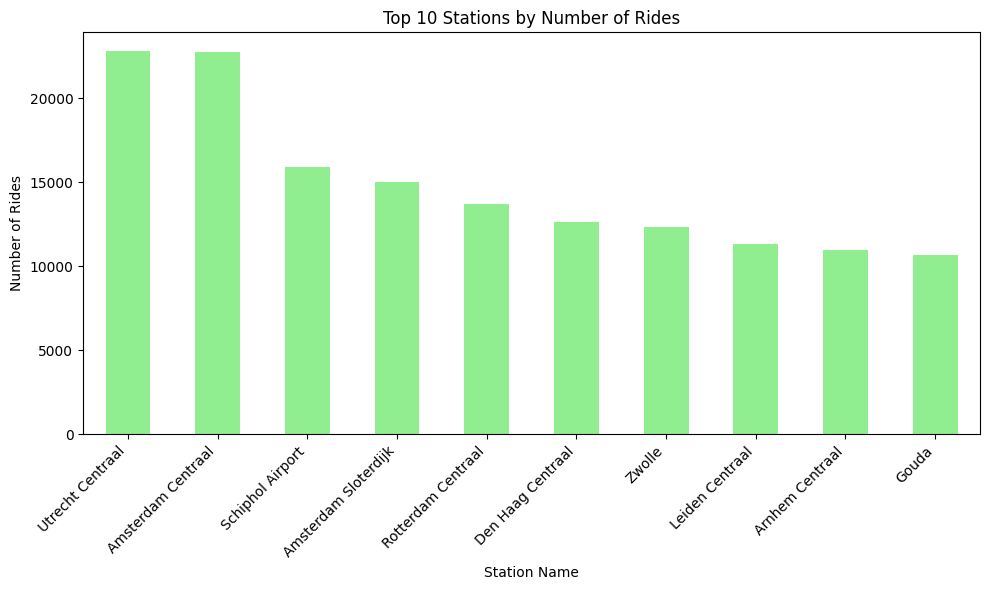

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

df_rides = pd.read_csv("NS_Data\combined_trein_data.csv", nrows=1_000_000)
print(f'There are: {df_rides.shape[0]} rides in the dataset.')

# Get the amount of rides per station
station_counts = df_rides['Stop:Station name'].value_counts()
top_10_stations = station_counts.head(10)

# Get the amount of rides that did not arrive on the planned platform
df_rides['platform_changed'] = df_rides['Stop:Planned platform'].astype(str) != df_rides['Stop:Actual platform'].astype(str)
num_changed = df_rides['platform_changed'].sum()
perc_changes = (num_changed / df_rides.shape[0]) * 100
print(f'Number of rides with platform changes: {num_changed} ({perc_changes:.2}%)')

# Plot bar graph for top 10 stations
plt.figure(figsize=(10,6))
top_10_stations.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Stations by Number of Rides')
plt.xlabel('Station Name')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Train Services
Percentage of fully canceled vs partly canceled services
<br>Average delay per operator (NS, Arriva, etc.)
<br>Top 10 train numbers with the most delays
<br>Distribution of delays (e.g., <5 min, 5–15 min, >30 min)
<br>Platform changes per station or by train type (Intercity vs Sprinter)
<br>Punctuality by time of day

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\bramm\AppData\Local\Temp\ipykernel_3704\1526610449.py:1: SyntaxWarning: invalid escape sequence '\c'
  df_rides = pd.read_csv("NS_Data\combined_trein_data.csv", nrows=100_000)


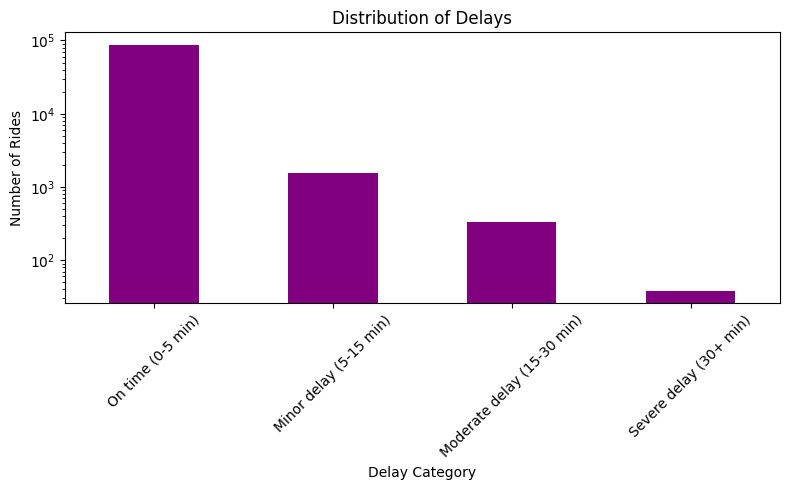

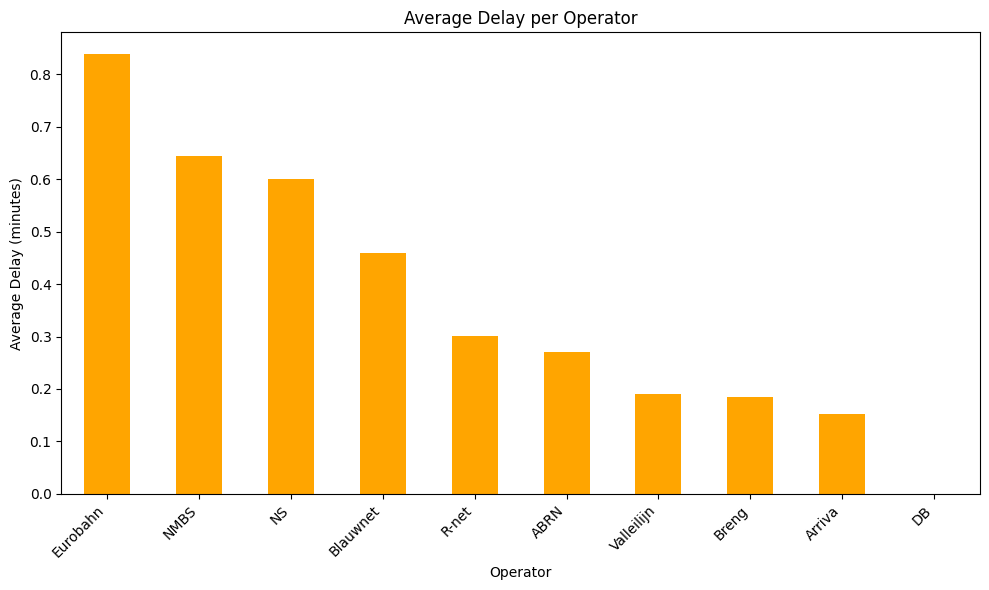

In [37]:
df_rides = pd.read_csv("NS_Data\combined_trein_data.csv", nrows=100_000)

df_rides['delay'] = pd.to_numeric(df_rides['Stop:Departure delay'], errors='coerce')
avg_delay_per_operator = df_rides.groupby('Service:Company')['delay'].mean().sort_values(ascending=False)

bins = [0, 5, 15, 30, df_rides['delay'].max()]
labels = ['On time (0-5 min)', 'Minor delay (5-15 min)', 'Moderate delay (15-30 min)', 'Severe delay (30+ min)']
df_rides['delay_group'] = pd.cut(df_rides['delay'], bins=bins, labels=labels, right=False, include_lowest=True)

delay_distribution = df_rides['delay_group'].value_counts().reindex(labels)


# Plot bar graph for delay distribution
plt.figure(figsize=(8,5))
delay_distribution.plot(kind='bar', logy=True, color='purple')
plt.title('Distribution of Delays')
plt.xlabel('Delay Category')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Make bar graph per operator
plt.figure(figsize=(10,6))
avg_delay_per_operator.plot(kind='bar', color='orange')
plt.title('Average Delay per Operator')
plt.xlabel('Operator')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


I would like delays more than 3 minutes per 4 hours

In [38]:
import pandas as pd

# === Step 1: Load your dataset ===
# Make sure this matches your file path or adjust if needed
file_path = "combined_disruptions_data.csv"
df = pd.read_csv(file_path)

# === Step 2: Count occurrences of each cause ===
# Replace 'cause_en' with the correct column name if it differs
if 'cause_en' not in df.columns:
    raise ValueError("Column 'cause_en' not found in the dataset. Please check the CSV headers.")

cause_counts = df['cause_en'].value_counts(dropna=False)

# === Step 3: Save the results to a text file ===
output_file = "disruption_causes_counts.txt"
with open(output_file, "w", encoding="utf-8") as f:
    for cause, count in cause_counts.items():
        f.write(f"{cause}\t{count}\n")

print(f"Export complete: {len(cause_counts)} unique causes written to '{output_file}'")


Export complete: 99 unique causes written to 'disruption_causes_counts.txt'


C:\Users\bramm\AppData\Local\Temp\ipykernel_3704\650393278.py:6: DtypeWarning: Columns (0,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


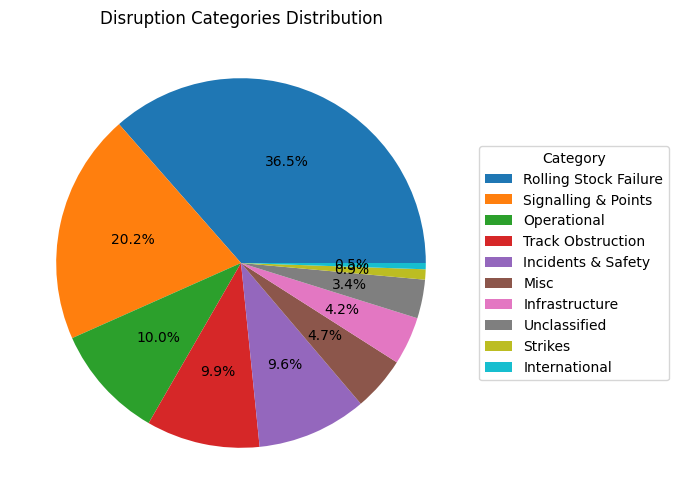

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("merged_cause_classification.csv")

category_totals = df.groupby("category")['frequency'].sum().sort_values(ascending=False)

percentages = category_totals / category_totals.sum() * 100
category_totals_filtered = category_totals[percentages >= 0.5]

plt.figure(figsize=(10,6))
plt.pie(category_totals_filtered, autopct='%1.1f%%')
plt.title('Disruption Categories Distribution')
plt.legend(category_totals.index, title="Category", loc="center left", bbox_to_anchor=(1, 0.5))
#plt.tight_layout()
plt.show()

